In [1]:
# Full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, math, subprocess
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import display

# 
from lib_modeling import *
from lib_feature_engineering import *

# some settings for displaying Pandas results
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', -1)

# Load data

In [4]:
# load train data
data_path = "home-credit-default-risk/application_train.csv"
pdf_train = pd.read_csv(data_path)

# filter by tvt code
pdf_tvt_extend = pd.read_pickle("pdf_tvt_extend.pkl", compression="bz2")
pdf_train_filtered = (pdf_tvt_extend.query("tvt_code == 'train'")
                      .merge(pdf_train[["SK_ID_CURR"]], on="SK_ID_CURR")
                      .drop(columns=["tvt_code"]))
pdf_train_filtered.head()

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
2,100004,0
3,100006,0
4,100007,0


In [5]:
# load bureau
data_path = "home-credit-default-risk/bureau.csv"
pdf_data = pd.read_csv(data_path)

# Preprocess data

## onehot and frequency

- CREDIT_ACTIVE: Tình trạng của khoản vay
- CREDIT_CURRENCY

In [6]:
# những khoản vay bị bán (Sold) được xem là (Bad debt)
print("Before")
print(pdf_data["CREDIT_ACTIVE"].value_counts())

pdf_data.loc[pdf_data["CREDIT_ACTIVE"] == "Sold", "CREDIT_ACTIVE"] = "Bad debt"
print("After")
print(pdf_data["CREDIT_ACTIVE"].value_counts())

Before
Closed      1079273
Active      630607 
Sold        6527   
Bad debt    21     
Name: CREDIT_ACTIVE, dtype: int64
After
Closed      1079273
Active      630607 
Bad debt    6548   
Name: CREDIT_ACTIVE, dtype: int64


In [7]:
# những currency hiếm gặp sẽ đưa vào chung một loại currency 2
print("Before")
print(pdf_data["CREDIT_CURRENCY"].value_counts())

pdf_data.loc[pdf_data["CREDIT_CURRENCY"].isin(["currency 3", "currency 4"]), "CREDIT_CURRENCY"] = "currency 2"
print("After")
print(pdf_data["CREDIT_CURRENCY"].value_counts())

Before
currency 1    1715020
currency 2    1224   
currency 3    174    
currency 4    10     
Name: CREDIT_CURRENCY, dtype: int64
After
currency 1    1715020
currency 2    1408   
Name: CREDIT_CURRENCY, dtype: int64


In [8]:
pdf_distr_credit_type = pdf_data["CREDIT_TYPE"].value_counts().to_frame("freq")
pdf_distr_credit_type

,freq
Consumer credit,1251615
Credit card,402195
Car loan,27690
Mortgage,18391
Microloan,12413
Loan for business development,1975
Another type of loan,1017
Unknown type of loan,555
Loan for working capital replenishment,469
Cash loan (non-earmarked),56


In [9]:
pdf_check_credit_type = pdf_train_filtered.merge(pdf_data[["SK_ID_CURR", "CREDIT_TYPE"]]).groupby(["CREDIT_TYPE", "TARGET"]).size().to_frame("count")
pdf_check_credit_type = pdf_check_credit_type.reset_index().set_index("CREDIT_TYPE")

# 
pdf_pct = pdf_check_credit_type.query("TARGET == 1").join(pdf_distr_credit_type)
pdf_pct["pct"] = pdf_pct["count"] * 100.0 / pdf_pct["freq"]
pdf_pct.sort_values("pct")

,TARGET,count,freq,pct
CREDIT_TYPE,,,,
Mortgage,1,545,18391,2.9634
Car loan,1,892,27690,3.2214
Loan for business development,1,76,1975,3.8481
Unknown type of loan,1,22,555,3.9640
Another type of loan,1,45,1017,4.4248
Consumer credit,1,56552,1251615,4.5183
Credit card,1,21562,402195,5.3611
Loan for working capital replenishment,1,31,469,6.6098
Microloan,1,1357,12413,10.9321


In [10]:
# dựa vào phần trăm tín dụng xấu lớn hơn 5% và có phân bố nhỏ sẽ được xếp vào good/bad loan
ls_good_loan = [
    "Mobile operator loan",
    "Interbank credit",
    "Loan for purchase of shares (margin lending)",
    "Real estate loan"
    "Cash loan (non-earmarked)",
    "Another type of loan"
]

ls_bad_loan = [
    "Loan for the purchase of equipment",
    "Microloan",
    "Loan for working capital replenishment"
]

pdf_data.loc[pdf_data["CREDIT_TYPE"].isin(ls_good_loan), "CREDIT_TYPE"] = "Consumer credit"
pdf_data.loc[pdf_data["CREDIT_TYPE"].isin(ls_bad_loan), "CREDIT_TYPE"] = "Bad loan"

print("After")
print(pdf_data["CREDIT_TYPE"].value_counts())

After
Consumer credit                  1252638
Credit card                      402195 
Car loan                         27690  
Mortgage                         18391  
Bad loan                         12901  
Loan for business development    1975   
Unknown type of loan             555    
Cash loan (non-earmarked)        56     
Real estate loan                 27     
Name: CREDIT_TYPE, dtype: int64


In [11]:
%%time
dict_feat = {
    "CREDIT_ACTIVE": ['Closed', 'Active', 'Bad debt'],
    "CREDIT_CURRENCY": ['currency 1', 'currency 2'],
    "CREDIT_TYPE": ["Consumer credit", "Credit card", "Car loan", "Mortgage", "Loan for business development", "Unknown type of loan", "Bad loan"],
}
pdf_onehot = gen_one_hot_feat(pdf_data, dict_feat)

CPU times: user 30 s, sys: 1.14 s, total: 31.1 s
Wall time: 8.29 s


In [12]:
pdf_agg01 = agg_common_data(pdf_onehot, ["max", "sum", "mean"])
eval_agg01 = feature_evaluate(pdf_train_filtered, pdf_agg01.reset_index())
display(eval_agg01)

{'CREDIT_ACTIVE_Active': ['max', 'sum', 'mean'],
 'CREDIT_ACTIVE_Bad_debt': ['max', 'sum', 'mean'],
 'CREDIT_ACTIVE_Closed': ['max', 'sum', 'mean'],
 'CREDIT_CURRENCY_currency_1': ['max', 'sum', 'mean'],
 'CREDIT_CURRENCY_currency_2': ['max', 'sum', 'mean'],
 'CREDIT_TYPE_Bad_loan': ['max', 'sum', 'mean'],
 'CREDIT_TYPE_Car_loan': ['max', 'sum', 'mean'],
 'CREDIT_TYPE_Consumer_credit': ['max', 'sum', 'mean'],
 'CREDIT_TYPE_Credit_card': ['max', 'sum', 'mean'],
 'CREDIT_TYPE_Loan_for_business_development': ['max', 'sum', 'mean'],
 'CREDIT_TYPE_Mortgage': ['max', 'sum', 'mean'],
 'CREDIT_TYPE_Unknown_type_of_loan': ['max', 'sum', 'mean']}

After agg: (305811, 36)


,name,auc,corr,coverage
5,CREDIT_ACTIVE_Closed_mean,0.5881,-0.0812,1.0
23,CREDIT_ACTIVE_Active_mean,0.5856,0.0788,1.0
22,CREDIT_ACTIVE_Active_sum,0.5600,0.0662,1.0
4,CREDIT_ACTIVE_Closed_sum,0.5490,-0.0319,1.0
8,CREDIT_TYPE_Credit_card_mean,0.5377,0.0359,1.0
7,CREDIT_TYPE_Credit_card_sum,0.5306,0.0357,1.0
20,CREDIT_TYPE_Consumer_credit_mean,0.5305,-0.0271,1.0
3,CREDIT_ACTIVE_Closed_max,0.5303,-0.0487,1.0
21,CREDIT_ACTIVE_Active_max,0.5261,0.0368,1.0
19,CREDIT_TYPE_Consumer_credit_sum,0.5193,-0.0126,1.0


In [13]:
eval_agg01.query("auc <= 0.501").shape

(11, 4)

In [14]:
sel_feat = eval_agg01.query("auc > 0.501")["name"].tolist()
pdf_agg01 = pdf_agg01[sel_feat]
print(pdf_agg01.shape)

(305811, 25)


## days to years

- DAYS_CREDIT: Ngày vay so với hiện tại
- CREDIT_DAY_OVERDUE
- DAYS_CREDIT_UPDATE
- DAYS_CREDIT_ENDDATE
- DAYS_ENDDATE_FACT

In [15]:
def days_to_years(pdf_input, ls_cols):
    pdf_out = pdf_input[["SK_ID_CURR"] + ls_cols].copy()
    col_out = []
    for cname in ls_cols:
        new_name = "{}_TO_YEARS".format(cname)
        col_out.append(new_name)
        pdf_out[new_name] = pdf_out["DAYS_CREDIT"] / -365
        
    return pdf_out[["SK_ID_CURR"] + col_out]

In [16]:
ls_cols = ["DAYS_CREDIT", "CREDIT_DAY_OVERDUE", "DAYS_CREDIT_UPDATE", "DAYS_CREDIT_ENDDATE", "DAYS_ENDDATE_FACT"]
pdf_years = days_to_years(pdf_data, ls_cols)
pdf_years.head()

,SK_ID_CURR,DAYS_CREDIT_TO_YEARS,CREDIT_DAY_OVERDUE_TO_YEARS,DAYS_CREDIT_UPDATE_TO_YEARS,DAYS_CREDIT_ENDDATE_TO_YEARS,DAYS_ENDDATE_FACT_TO_YEARS
0,215354,1.3616,1.3616,1.3616,1.3616,1.3616
1,215354,0.5699,0.5699,0.5699,0.5699,0.5699
2,215354,0.5562,0.5562,0.5562,0.5562,0.5562
3,215354,0.5562,0.5562,0.5562,0.5562,0.5562
4,215354,1.7233,1.7233,1.7233,1.7233,1.7233


In [17]:
pdf_agg02 = agg_common_data(pdf_years, ["min", "max", "mean", "std", "median"])
pdf_agg02.head()

{'CREDIT_DAY_OVERDUE_TO_YEARS': ['min', 'max', 'mean', 'std', 'median'],
 'DAYS_CREDIT_ENDDATE_TO_YEARS': ['min', 'max', 'mean', 'std', 'median'],
 'DAYS_CREDIT_TO_YEARS': ['min', 'max', 'mean', 'std', 'median'],
 'DAYS_CREDIT_UPDATE_TO_YEARS': ['min', 'max', 'mean', 'std', 'median'],
 'DAYS_ENDDATE_FACT_TO_YEARS': ['min', 'max', 'mean', 'std', 'median']}

After agg: (305811, 25)


,DAYS_CREDIT_UPDATE_TO_YEARS_min,DAYS_CREDIT_UPDATE_TO_YEARS_max,DAYS_CREDIT_UPDATE_TO_YEARS_mean,DAYS_CREDIT_UPDATE_TO_YEARS_std,DAYS_CREDIT_UPDATE_TO_YEARS_median,DAYS_CREDIT_ENDDATE_TO_YEARS_min,DAYS_CREDIT_ENDDATE_TO_YEARS_max,DAYS_CREDIT_ENDDATE_TO_YEARS_mean,DAYS_CREDIT_ENDDATE_TO_YEARS_std,DAYS_CREDIT_ENDDATE_TO_YEARS_median,DAYS_ENDDATE_FACT_TO_YEARS_min,DAYS_ENDDATE_FACT_TO_YEARS_max,DAYS_ENDDATE_FACT_TO_YEARS_mean,DAYS_ENDDATE_FACT_TO_YEARS_std,DAYS_ENDDATE_FACT_TO_YEARS_median,DAYS_CREDIT_TO_YEARS_min,DAYS_CREDIT_TO_YEARS_max,DAYS_CREDIT_TO_YEARS_mean,DAYS_CREDIT_TO_YEARS_std,DAYS_CREDIT_TO_YEARS_median,CREDIT_DAY_OVERDUE_TO_YEARS_min,CREDIT_DAY_OVERDUE_TO_YEARS_max,CREDIT_DAY_OVERDUE_TO_YEARS_mean,CREDIT_DAY_OVERDUE_TO_YEARS_std,CREDIT_DAY_OVERDUE_TO_YEARS_median
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,
100001,0.1342,4.3068,2.0137,1.3423,2.3479,0.1342,4.3068,2.0137,1.3423,2.3479,0.1342,4.3068,2.0137,1.3423,2.3479,0.1342,4.3068,2.0137,1.3423,2.3479,0.1342,4.3068,2.0137,1.3423,2.3479
100002,0.2822,3.9370,2.3945,1.1821,2.8562,0.2822,3.9370,2.3945,1.1821,2.8562,0.2822,3.9370,2.3945,1.1821,2.8562,0.2822,3.9370,2.3945,1.1821,2.8562,0.2822,3.9370,2.3945,1.1821,2.8562
100003,1.6603,7.0849,3.8377,2.4927,3.3027,1.6603,7.0849,3.8377,2.4927,3.3027,1.6603,7.0849,3.8377,2.4927,3.3027,1.6603,7.0849,3.8377,2.4927,3.3027,1.6603,7.0849,3.8377,2.4927,3.3027
100004,1.1178,3.6329,2.3753,1.7784,2.3753,1.1178,3.6329,2.3753,1.7784,2.3753,1.1178,3.6329,2.3753,1.7784,2.3753,1.1178,3.6329,2.3753,1.7784,2.3753,1.1178,3.6329,2.3753,1.7784,2.3753
100005,0.1699,1.0219,0.5224,0.4446,0.3753,0.1699,1.0219,0.5224,0.4446,0.3753,0.1699,1.0219,0.5224,0.4446,0.3753,0.1699,1.0219,0.5224,0.4446,0.3753,0.1699,1.0219,0.5224,0.4446,0.3753


In [18]:
eval_agg02 = feature_evaluate(pdf_train_filtered, pdf_agg02.reset_index())
display(eval_agg02)

,name,auc,corr,coverage
12,DAYS_ENDDATE_FACT_TO_YEARS_mean,0.6043,-0.0912,1.0000
2,DAYS_CREDIT_UPDATE_TO_YEARS_mean,0.6043,-0.0912,1.0000
22,CREDIT_DAY_OVERDUE_TO_YEARS_mean,0.6043,-0.0912,1.0000
17,DAYS_CREDIT_TO_YEARS_mean,0.6043,-0.0912,1.0000
7,DAYS_CREDIT_ENDDATE_TO_YEARS_mean,0.6043,-0.0912,1.0000
9,DAYS_CREDIT_ENDDATE_TO_YEARS_median,0.6042,-0.0877,1.0000
19,DAYS_CREDIT_TO_YEARS_median,0.6042,-0.0877,1.0000
14,DAYS_ENDDATE_FACT_TO_YEARS_median,0.6042,-0.0877,1.0000
24,CREDIT_DAY_OVERDUE_TO_YEARS_median,0.6042,-0.0877,1.0000
4,DAYS_CREDIT_UPDATE_TO_YEARS_median,0.6042,-0.0877,1.0000


## khách hàng sử dụng trong vòng 1 năm

In [19]:
pdf_filtered021 = pdf_years[["SK_ID_CURR", "DAYS_CREDIT_TO_YEARS"]].copy()
pdf_filtered021["YEARS_CREDIT_1year"] = 0
idx_query = (pdf_years["DAYS_CREDIT_TO_YEARS"] >=1) & (pdf_years["DAYS_CREDIT_TO_YEARS"] < 2)
pdf_filtered021.loc[idx_query, "YEARS_CREDIT_1year"] = 1
pdf_filtered021.drop(columns=["DAYS_CREDIT_TO_YEARS"], inplace=True)

# 
pdf_agg021 = agg_common_data(pdf_filtered021, ["max", "sum"])
eval_agg021 = feature_evaluate(pdf_train_filtered, pdf_agg021.reset_index())
display(eval_agg021)

{'YEARS_CREDIT_1year': ['max', 'sum']}

After agg: (305811, 2)


,name,auc,corr,coverage
1,YEARS_CREDIT_1year_sum,0.5227,0.0317,1.0
0,YEARS_CREDIT_1year_max,0.5110,0.0119,1.0


## khách hàng sử dụng trong vòng 2 năm

In [20]:
pdf_filtered022 = pdf_years[["SK_ID_CURR", "DAYS_CREDIT_TO_YEARS"]].copy()
pdf_filtered022["YEARS_CREDIT_2year"] = 0
idx_query = (pdf_years["DAYS_CREDIT_TO_YEARS"] >= 2) & (pdf_years["DAYS_CREDIT_TO_YEARS"] < 3)
pdf_filtered022.loc[idx_query, "YEARS_CREDIT_2year"] = 1
pdf_filtered022.drop(columns=["DAYS_CREDIT_TO_YEARS"], inplace=True)

# 
pdf_agg022 = agg_common_data(pdf_filtered022, ["max", "sum"])
eval_agg022 = feature_evaluate(pdf_train_filtered, pdf_agg022.reset_index())
display(eval_agg022)

{'YEARS_CREDIT_2year': ['max', 'sum']}

After agg: (305811, 2)


,name,auc,corr,coverage
0,YEARS_CREDIT_2year_max,0.5204,-0.0219,1.0
1,YEARS_CREDIT_2year_sum,0.5189,-0.0097,1.0


## khách hàng sử dụng trong vòng lâu năm

In [21]:
pdf_filtered023 = pdf_years[["SK_ID_CURR", "DAYS_CREDIT_TO_YEARS"]].copy()
pdf_filtered023["YEARS_CREDIT_3year"] = 0
idx_query = pdf_years["DAYS_CREDIT_TO_YEARS"] >= 3
pdf_filtered023.loc[idx_query, "YEARS_CREDIT_3year"] = 1
pdf_filtered023.drop(columns=["DAYS_CREDIT_TO_YEARS"], inplace=True)

# 
pdf_agg023 = agg_common_data(pdf_filtered023, ["max", "sum"])
eval_agg023 = feature_evaluate(pdf_train_filtered, pdf_agg023.reset_index())
display(eval_agg023)

{'YEARS_CREDIT_3year': ['max', 'sum']}

After agg: (305811, 2)


,name,auc,corr,coverage
1,YEARS_CREDIT_3year_sum,0.5698,-0.0514,1.0
0,YEARS_CREDIT_3year_max,0.5567,-0.0685,1.0


## keep columns

In [22]:
ls_cols = [cname for cname in pdf_data.columns if "AMT" in cname] + ["CNT_CREDIT_PROLONG"]
pdf_amt = pdf_data[["SK_ID_CURR"] + ls_cols]
pdf_amt.head()

,SK_ID_CURR,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_ANNUITY,CNT_CREDIT_PROLONG
0,215354,NaN,91323.0,0.0,NaN,0.0,NaN,0
1,215354,NaN,225000.0,171342.0,NaN,0.0,NaN,0
2,215354,NaN,464323.5,NaN,NaN,0.0,NaN,0
3,215354,NaN,90000.0,NaN,NaN,0.0,NaN,0
4,215354,77674.5,2700000.0,NaN,NaN,0.0,NaN,0


In [23]:
pdf_agg03 = agg_common_data(pdf_amt, ["min", "max", "mean", "std", "median"])

{'AMT_ANNUITY': ['min', 'max', 'mean', 'std', 'median'],
 'AMT_CREDIT_MAX_OVERDUE': ['min', 'max', 'mean', 'std', 'median'],
 'AMT_CREDIT_SUM': ['min', 'max', 'mean', 'std', 'median'],
 'AMT_CREDIT_SUM_DEBT': ['min', 'max', 'mean', 'std', 'median'],
 'AMT_CREDIT_SUM_LIMIT': ['min', 'max', 'mean', 'std', 'median'],
 'AMT_CREDIT_SUM_OVERDUE': ['min', 'max', 'mean', 'std', 'median'],
 'CNT_CREDIT_PROLONG': ['min', 'max', 'mean', 'std', 'median']}

After agg: (305811, 35)


In [24]:
eval_agg03 = feature_evaluate(pdf_train_filtered, pdf_agg03.reset_index())
display(eval_agg03)

,name,auc,corr,coverage
24,AMT_CREDIT_SUM_DEBT_median,0.5582,0.0022,0.9721
22,AMT_CREDIT_SUM_DEBT_mean,0.5578,-0.0004,0.9721
13,AMT_CREDIT_MAX_OVERDUE_std,0.5506,0.0004,0.4506
23,AMT_CREDIT_SUM_DEBT_std,0.5497,-0.0039,0.8123
12,AMT_CREDIT_MAX_OVERDUE_mean,0.5477,0.0080,0.6988
11,AMT_CREDIT_MAX_OVERDUE_max,0.5456,0.0048,0.6988
21,AMT_CREDIT_SUM_DEBT_max,0.5452,-0.0029,0.9721
14,AMT_CREDIT_MAX_OVERDUE_median,0.5331,0.0077,0.6988
18,AMT_CREDIT_SUM_LIMIT_std,0.5309,-0.0130,0.7283
34,AMT_ANNUITY_median,0.5283,-0.0011,0.3042


In [25]:
eval_agg03.query("auc <= 0.501").shape

(4, 4)

In [26]:
sel_feat = eval_agg03.query("auc > 0.501")["name"].tolist()
pdf_agg03 = pdf_agg03[sel_feat]
print(pdf_agg03.shape)

(305811, 31)


# save features

In [27]:
pdf_feat = pdf_agg01.join(pdf_agg02).join(pdf_agg03).join(pdf_agg021).join(pdf_agg022).join(pdf_agg023)
print(pdf_feat.shape)
pdf_feat.head()

(305811, 87)


,CREDIT_ACTIVE_Closed_mean,CREDIT_ACTIVE_Active_mean,CREDIT_ACTIVE_Active_sum,CREDIT_ACTIVE_Closed_sum,CREDIT_TYPE_Credit_card_mean,CREDIT_TYPE_Credit_card_sum,CREDIT_TYPE_Consumer_credit_mean,CREDIT_ACTIVE_Closed_max,CREDIT_ACTIVE_Active_max,CREDIT_TYPE_Consumer_credit_sum,CREDIT_TYPE_Credit_card_max,CREDIT_TYPE_Bad_loan_sum,CREDIT_TYPE_Bad_loan_mean,CREDIT_TYPE_Bad_loan_max,CREDIT_TYPE_Car_loan_mean,CREDIT_TYPE_Car_loan_sum,CREDIT_TYPE_Car_loan_max,CREDIT_TYPE_Mortgage_mean,CREDIT_TYPE_Mortgage_sum,CREDIT_TYPE_Mortgage_max,CREDIT_CURRENCY_currency_1_sum,CREDIT_TYPE_Consumer_credit_max,CREDIT_ACTIVE_Bad_debt_mean,CREDIT_ACTIVE_Bad_debt_max,CREDIT_ACTIVE_Bad_debt_sum,DAYS_CREDIT_UPDATE_TO_YEARS_min,DAYS_CREDIT_UPDATE_TO_YEARS_max,DAYS_CREDIT_UPDATE_TO_YEARS_mean,DAYS_CREDIT_UPDATE_TO_YEARS_std,DAYS_CREDIT_UPDATE_TO_YEARS_median,DAYS_CREDIT_ENDDATE_TO_YEARS_min,DAYS_CREDIT_ENDDATE_TO_YEARS_max,DAYS_CREDIT_ENDDATE_TO_YEARS_mean,DAYS_CREDIT_ENDDATE_TO_YEARS_std,DAYS_CREDIT_ENDDATE_TO_YEARS_median,DAYS_ENDDATE_FACT_TO_YEARS_min,DAYS_ENDDATE_FACT_TO_YEARS_max,DAYS_ENDDATE_FACT_TO_YEARS_mean,DAYS_ENDDATE_FACT_TO_YEARS_std,DAYS_ENDDATE_FACT_TO_YEARS_median,DAYS_CREDIT_TO_YEARS_min,DAYS_CREDIT_TO_YEARS_max,DAYS_CREDIT_TO_YEARS_mean,DAYS_CREDIT_TO_YEARS_std,DAYS_CREDIT_TO_YEARS_median,CREDIT_DAY_OVERDUE_TO_YEARS_min,CREDIT_DAY_OVERDUE_TO_YEARS_max,CREDIT_DAY_OVERDUE_TO_YEARS_mean,CREDIT_DAY_OVERDUE_TO_YEARS_std,CREDIT_DAY_OVERDUE_TO_YEARS_median,AMT_CREDIT_SUM_DEBT_median,AMT_CREDIT_SUM_DEBT_mean,AMT_CREDIT_MAX_OVERDUE_std,AMT_CREDIT_SUM_DEBT_std,AMT_CREDIT_MAX_OVERDUE_mean,AMT_CREDIT_MAX_OVERDUE_max,AMT_CREDIT_SUM_DEBT_max,AMT_CREDIT_MAX_OVERDUE_median,AMT_CREDIT_SUM_LIMIT_std,AMT_ANNUITY_median,AMT_CREDIT_SUM_DEBT_min,AMT_CREDIT_SUM_LIMIT_max,AMT_CREDIT_SUM_LIMIT_mean,AMT_ANNUITY_mean,AMT_CREDIT_SUM_median,AMT_CREDIT_SUM_min,AMT_ANNUITY_std,AMT_ANNUITY_min,AMT_CREDIT_SUM_mean,AMT_CREDIT_MAX_OVERDUE_min,AMT_ANNUITY_max,AMT_CREDIT_SUM_max,AMT_CREDIT_SUM_OVERDUE_std,AMT_CREDIT_SUM_OVERDUE_mean,AMT_CREDIT_SUM_OVERDUE_max,AMT_CREDIT_SUM_LIMIT_median,AMT_CREDIT_SUM_std,CNT_CREDIT_PROLONG_std,CNT_CREDIT_PROLONG_max,CNT_CREDIT_PROLONG_mean,AMT_CREDIT_SUM_OVERDUE_median,YEARS_CREDIT_1year_max,YEARS_CREDIT_1year_sum,YEARS_CREDIT_2year_max,YEARS_CREDIT_2year_sum,YEARS_CREDIT_3year_max,YEARS_CREDIT_3year_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,0.5714,0.4286,3,4,0.0000,0,1.0000,1,1,7,0,0,0.0,0,0.0,0,0,0.0,0,0,7,1,0.0,0,0,0.1342,4.3068,2.0137,1.3423,2.3479,0.1342,4.3068,2.0137,1.3423,2.3479,0.1342,4.3068,2.0137,1.3423,2.3479,0.1342,4.3068,2.0137,1.3423,2.3479,0.1342,4.3068,2.0137,1.3423,2.3479,0.0,85240.9286,NaN,137485.6311,NaN,NaN,373239.0,NaN,0.0000,0.0,0.0,0.000,0.0000,3545.3571,168345.00,85500.0,4800.6075,0.0,207623.5714,NaN,10822.5,378000.0,0.0,0.0,0.0,0.0,122544.5445,0.0,0,0.0,0.0,1,1,1,3,1,1
100002,0.7500,0.2500,2,6,0.5000,4,0.5000,1,1,4,1,0,0.0,0,0.0,0,0,0.0,0,0,8,1,0.0,0,0,0.2822,3.9370,2.3945,1.1821,2.8562,0.2822,3.9370,2.3945,1.1821,2.8562,0.2822,3.9370,2.3945,1.1821,2.8562,0.2822,3.9370,2.3945,1.1821,2.8562,0.2822,3.9370,2.3945,1.1821,2.8562,0.0,49156.2000,2363.2469,109916.6047,1681.029,5043.645,245781.0,40.5,15994.2825,0.0,0.0,31988.565,7997.1412,0.0000,54130.50,0.0,0.0000,0.0,108131.9456,0.0,0.0,450000.0,0.0,0.0,0.0,0.0,146075.5574,0.0,0,0.0,0.0,1,2,1,2,1,3
100003,0.7500,0.2500,1,3,0.5000,2,0.5000,1,1,2,1,0,0.0,0,0.0,0,0,0.0,0,0,4,1,0.0,0,0,1.6603,7.0849,3.8377,2.4927,3.3027,1.6603,7.0849,3.8377,2.4927,3.3027,1.6603,7.0849,3.8377,2.4927,3.3027,1.6603,7.0849,3.8377,2.4927,3.3027,1.6603,7.0849,3.8377,2.4927,3.3027,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0,0.0,405000.0000,NaN,0.0,810000.000,202500.0000,NaN,92576.25,22248.0,NaN,NaN,254350.1250,0.0,NaN,810000.0,0.0,0.0,0.0,0.0,372269.4655,0.0,0,0.0,0.0,1,1,1,1,1,2
100004,1.0000,0.0000,0,2,0.0000,0,1.0000,1,0,2,0,0,0.0,0,0.0,0,0,0.0,0,0,2,1,0.0,0,0,1.1178,3.6329,2.3753,1.7784,2.3753,1.1178,3.6329,2.3753,1.7784,2.3753,1.117

In [28]:
%%time
fname = "bureau"
fname = os.path.join("features", "{}.pkl.bz2".format(fname))
pdf_feat.to_pickle(fname, compression="bz2")
print("Store features completed!")


Store features completed!
CPU times: user 11.6 s, sys: 211 ms, total: 11.9 s
Wall time: 11.2 s


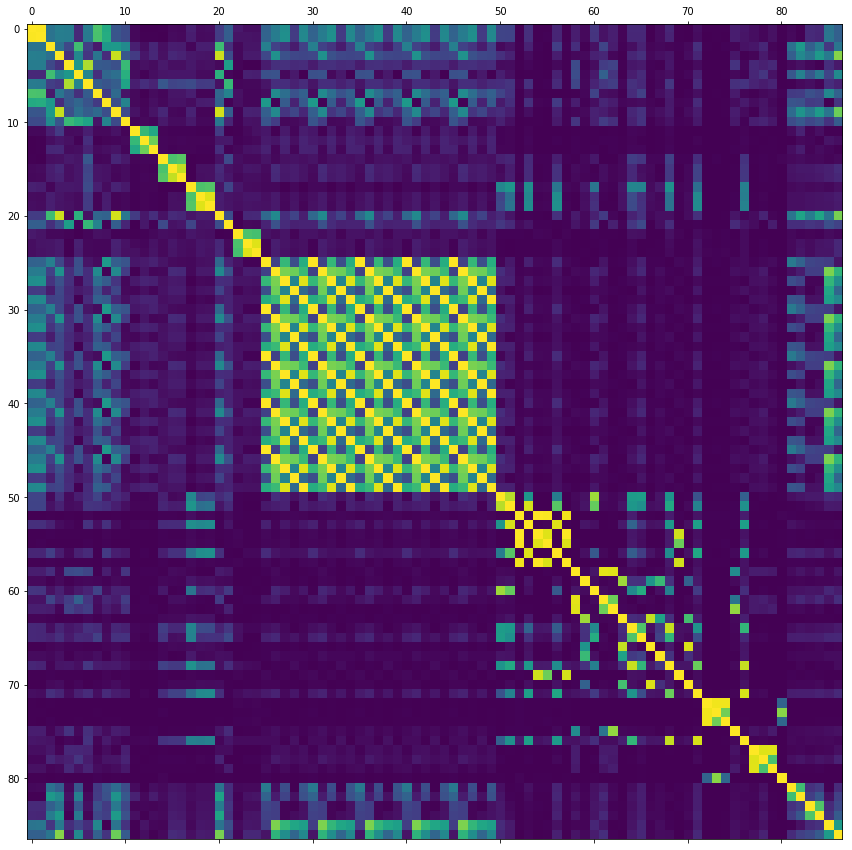

,CREDIT_ACTIVE_Closed_mean,CREDIT_ACTIVE_Active_mean,CREDIT_ACTIVE_Active_sum,CREDIT_ACTIVE_Closed_sum,CREDIT_TYPE_Credit_card_mean,CREDIT_TYPE_Credit_card_sum,CREDIT_TYPE_Consumer_credit_mean,CREDIT_ACTIVE_Closed_max,CREDIT_ACTIVE_Active_max,CREDIT_TYPE_Consumer_credit_sum,CREDIT_TYPE_Credit_card_max,CREDIT_TYPE_Bad_loan_sum,CREDIT_TYPE_Bad_loan_mean,CREDIT_TYPE_Bad_loan_max,CREDIT_TYPE_Car_loan_mean,CREDIT_TYPE_Car_loan_sum,CREDIT_TYPE_Car_loan_max,CREDIT_TYPE_Mortgage_mean,CREDIT_TYPE_Mortgage_sum,CREDIT_TYPE_Mortgage_max,CREDIT_CURRENCY_currency_1_sum,CREDIT_TYPE_Consumer_credit_max,CREDIT_ACTIVE_Bad_debt_mean,CREDIT_ACTIVE_Bad_debt_max,CREDIT_ACTIVE_Bad_debt_sum,DAYS_CREDIT_UPDATE_TO_YEARS_min,DAYS_CREDIT_UPDATE_TO_YEARS_max,DAYS_CREDIT_UPDATE_TO_YEARS_mean,DAYS_CREDIT_UPDATE_TO_YEARS_std,DAYS_CREDIT_UPDATE_TO_YEARS_median,DAYS_CREDIT_ENDDATE_TO_YEARS_min,DAYS_CREDIT_ENDDATE_TO_YEARS_max,DAYS_CREDIT_ENDDATE_TO_YEARS_mean,DAYS_CREDIT_ENDDATE_TO_YEARS_std,DAYS_CREDIT_ENDDATE_TO_YEARS_median,DAYS_ENDDATE_FACT_TO_YEARS_min,DAYS_ENDDATE_FACT_TO_YEARS_max,DAYS_ENDDATE_FACT_TO_YEARS_mean,DAYS_ENDDATE_FACT_TO_YEARS_std,DAYS_ENDDATE_FACT_TO_YEARS_median,DAYS_CREDIT_TO_YEARS_min,DAYS_CREDIT_TO_YEARS_max,DAYS_CREDIT_TO_YEARS_mean,DAYS_CREDIT_TO_YEARS_std,DAYS_CREDIT_TO_YEARS_median,CREDIT_DAY_OVERDUE_TO_YEARS_min,CREDIT_DAY_OVERDUE_TO_YEARS_max,CREDIT_DAY_OVERDUE_TO_YEARS_mean,CREDIT_DAY_OVERDUE_TO_YEARS_std,CREDIT_DAY_OVERDUE_TO_YEARS_median,AMT_CREDIT_SUM_DEBT_median,AMT_CREDIT_SUM_DEBT_mean,AMT_CREDIT_MAX_OVERDUE_std,AMT_CREDIT_SUM_DEBT_std,AMT_CREDIT_MAX_OVERDUE_mean,AMT_CREDIT_MAX_OVERDUE_max,AMT_CREDIT_SUM_DEBT_max,AMT_CREDIT_MAX_OVERDUE_median,AMT_CREDIT_SUM_LIMIT_std,AMT_ANNUITY_median,AMT_CREDIT_SUM_DEBT_min,AMT_CREDIT_SUM_LIMIT_max,AMT_CREDIT_SUM_LIMIT_mean,AMT_ANNUITY_mean,AMT_CREDIT_SUM_median,AMT_CREDIT_SUM_min,AMT_ANNUITY_std,AMT_ANNUITY_min,AMT_CREDIT_SUM_mean,AMT_CREDIT_MAX_OVERDUE_min,AMT_ANNUITY_max,AMT_CREDIT_SUM_max,AMT_CREDIT_SUM_OVERDUE_std,AMT_CREDIT_SUM_OVERDUE_mean,AMT_CREDIT_SUM_OVERDUE_max,AMT_CREDIT_SUM_LIMIT_median,AMT_CREDIT_SUM_std,CNT_CREDIT_PROLONG_std,CNT_CREDIT_PROLONG_max,CNT_CREDIT_PROLONG_mean,AMT_CREDIT_SUM_OVERDUE_median,YEARS_CREDIT_1year_max,YEARS_CREDIT_1year_sum,YEARS_CREDIT_2year_max,YEARS_CREDIT_2year_sum,YEARS_CREDIT_3year_max,YEARS_CREDIT_3year_sum
CREDIT_ACTIVE_Closed_mean,1.0000,-0.9926,-0.3794,0.4277,-0.4196,-1.1455e-01,4.1491e-01,0.7165,-0.6128,0.2661,-0.2228,0.0202,0.0028,0.0015,-0.0053,0.0266,0.0225,-0.0869,-0.0334,-0.0371,1.7626e-01,0.2995,-6.8824e-02,-0.0361,-0.0358,0.3131,0.4152,0.4899,0.1701,0.4618,0.3131,0.4152,0.4899,0.1701,0.4618,0.3131,0.4152,0.4899,0.1701,0.4618,0.3131,0.4152,0.4899,0.1701,0.4618,0.3131,0.4152,0.4899,0.1701,0.4618,-0.2050,-2.0153e-01,0.0003,-0.1367,5.4014e-03,5.9119e-03,-0.1025,4.8684e-03,-0.0809,-2.4016e-02,-1.5238e-01,-4.8149e-02,-0.0853,-1.5154e-02,-1.1492e-01,-0.1155,3.6310e-03,-2.8910e-02,-0.1067,5.3551e-03,3.1876e-03,-0.0363,-0.0050,-7.0908e-03,-4.6821e-03,-0.0791,-6.1916e-02,-3.5577e-02,-1.6602e-02,-4.3837e-02,-6.9705e-03,-0.0221,-0.0064,0.1201,0.1096,3.8671e-01,3.0589e-01
CREDIT_ACTIVE_Active_mean,-0.9926,1.0000,0.3826,-0.4256,0.4216,1.1454e-01,-4.1296e-01,-0.7116,0.6183,-0.2654,0.2240,-0.0211,-0.0040,-0.0040,0.0009,-0.0307,-0.0254,0.0797,0.0278,0.0321,-1.7644e-01,-0.2992,-5.3183e-02,-0.0513,-0.0504,-0.3194,-0.4198,-0.4969,-0.1721,-0.4684,-0.3194,-0.4198,-0.4969,-0.1721,-0.4684,-0.3194,-0.4198,-0.4969,-0.1721,-0.4684,-0.3194,-0.4198,-0.4969,-0.1721,-0.4684,-0.3194,-0.4198,-0.4969,-0.1721,-0.4684,0.2040,2.0062e-01,-0.0012,0.1363,-7.4144e-03,-7.8453e-03,0.1021,-6.8271e-03,0.0811,2.3609e-02,1.5126e-01,4.8662e-02,0.0859,1.4928e-02,1.0946e-01,0.1107,-3.7909e-03,2.8964e-02,0.1013,-7.2977e-03,-3.2719e-03,0.0328,0.0036,6.3541e-03,3.5218e-03,0.0795,5.8450e-02,3.5610e-02,1.6662e-02,4.3761e-02,6.7993e-03,0.0247,0.0077,-0.1185,-0.1087,-3.9071e-01,-3.0810e-01
CREDIT_ACTIVE_Active_sum,-0.3794,0.3826,1.0000,0.3672,0.2159,6.9464e-01,-1.8737e-01,0.0704,0.5329,0.5

In [29]:
def check_corr(pdf_input, attr=None, calculated=False):
    if calculated:
        pdf_corr = pdf_input
    else:
        pdf_corr = pdf_input.corr()    
    
    #
    toplot = pdf_corr
    fig, ax = plt.subplots(figsize=(15, 15))
    if attr is not None:
        idx_check = [name for name in pdf_corr.index if attr in name]
        toplot = pdf_corr.loc[idx_check, idx_check]
    
    ax.matshow(np.abs(toplot))
    plt.show()    
    display(toplot)
    
    return pdf_corr
    
#     
pdf_corr = check_corr(pdf_feat)